In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import threading
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imread
import numpy as np
from skimage.color import rgb2yuv
from skimage.feature import canny
from skimage.filters import sobel, median
import cv2
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn-pastel')

# Region Growing

In [2]:
def get_neighbours(x, y, img, mask, thresh):
    neighbours = []
    H, W = img.shape[:2]
    for i in [-1,0,1]:
        for j in [-1, 0, 1]:
            if abs(i) == abs(j):
                continue
            r = y+i
            c = x+j

            if r < 0 or r>= H or c < 0 or c>= W:
                continue
            elif not mask[r, c] and np.sqrt(np.sum((img[r, c] - img[y,x])**2)) <= thresh:
                neighbours.append((c, r))
    return neighbours

def region_grow(img, point, thresh):
    stack = [point]
    mask = np.zeros(img.shape[:2])
    while len(stack):
        x, y = stack.pop()
        if mask[y, x]:
            continue
        mask[y, x] = 1
        stack += get_neighbours(x, y, img, mask, thresh)
    out = img.copy()
    out[mask==0]=0
    return mask

In [3]:
def process_img(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked = True
        mask = region_grow(cv2.cvtColor(img, cv2.COLOR_BGR2LAB), (x, y), 2)
        out = img.copy()
        out[mask==0]=0
        cv2.imshow('out', out)
        cv2.waitKey(0)
        cv2.destroyWindow('out')
        
clicked = False
cv2.namedWindow('input')
cv2.setMouseCallback('input', process_img)
img = cv2.imread('madara.jpg')
img = cv2.GaussianBlur(img, (5, 5), 1)
while True:
    cv2.imshow('input', img)

    if 0xFF & cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()

# Automatic Thresholding

In [4]:
def my_automatic_threshold(img, init=None):
    cur_mean = np.mean(img) if init is None else init
    prev_mean = cur_mean

    while True:
        img_upper = img.copy()
        img_lower = img.copy()

        img_upper[img_upper <= cur_mean] = 0
        img_lower[img_lower >  cur_mean] = 0

        m1 = np.mean(img_upper)
        m2 = np.mean(img_lower)

        cur_mean = (m1 + m2)/2
        if abs(cur_mean - prev_mean) <= 0.01:
            ret, out = cv2.threshold(img, cur_mean, 1, cv2.THRESH_BINARY)
            print(ret)
            return out      
        prev_mean = cur_mean

0.1400062060673326


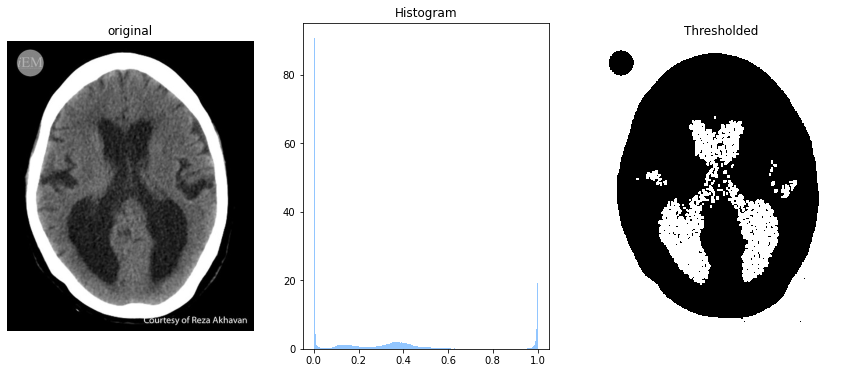

In [5]:
leaf = cv2.imread('leaf.jpg', 0)/255.0

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.title(f'original')
plt.imshow(leaf)
plt.axis('off')

plt.subplot(132)
plt.title('Histogram')
plt.hist(leaf.flat, bins=256, range=(0, 1), density=True)

plt.subplot(133)
plt.title(f'Thresholded')
plt.imshow(cv2.bitwise_not(my_automatic_threshold(leaf, 0.5)))
plt.axis('off')


plt.show()